In [434]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import List, Tuple


In [435]:
def read_image(path: str) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)


def show_image(image: np.ndarray, color=cv2.COLOR_GRAY2RGB) -> None:
    if color is not None:
        rgb_image = cv2.cvtColor(image, color)
    else:
        rgb_image = image
    plt.figure(figsize=(10, 14))
    plt.axis('off')

    plt.imshow(rgb_image)


In [436]:
image = read_image('exams/image--003.jpg')


In [437]:
def detect_contours(image: np.ndarray, threshold: int = 80) -> np.ndarray:
    new_image = image.copy()
    lower_black = np.array([0])
    upper_black = np.array([threshold])
    mask = cv2.inRange(new_image, lowerb=lower_black, upperb=upper_black)
    black_cnt = cv2.findContours(
        mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]
    return black_cnt


def find_squares(contours: np.ndarray, square_prop: float = 1.1) -> np.ndarray:
    def is_square(candidate: List[int]) -> bool:
        return max(candidate[2:])/min(candidate[2:]) <= square_prop
    return [contour for contour in contours if is_square(cv2.boundingRect(contour))]


def group_by_size(contours: np.ndarray, similarity_prop: float = 1.1) -> List[List[int]]:
    groupped = [[]]
    cont_idx, group_idx = 0, 0

    contours = drop_insignificant(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    while cont_idx < len(contours):
        if len(groupped[group_idx]) == 0 or cv2.contourArea(groupped[group_idx][0])/cv2.contourArea(contours[cont_idx]) < similarity_prop:
            groupped[group_idx].append(contours[cont_idx])
        else:
            groupped.append([contours[cont_idx]])
            group_idx += 1
        cont_idx += 1

    return groupped


def drop_insignificant(contours: np.ndarray, dropout: float = 400):
    return [contour for contour in contours if cv2.contourArea(contour) >= dropout]


def mark_contours(image: np.ndarray, contours: np.ndarray, frame_color: Tuple[int] = (0, 255, 0)) -> np.ndarray:
    if len(image.shape) == 2:
        new_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    else:
        new_image = image.copy()
    for m_area in contours:
        if len(m_area) != 4:
            (xg, yg, wg, hg) = cv2.boundingRect(m_area)
        else:
            (xg, yg, wg, hg) = m_area
        cv2.rectangle(new_image, (xg, yg), (xg+wg, yg+hg), frame_color, 2)
    return new_image


def calculate_rectangle(contours: np.ndarray, inside: bool = True) -> List[int]:
    contours = [cv2.boundingRect(contour) for contour in contours]
    right_x = [x[0] + x[2] for x in contours]
    bottom_y = [x[1] + x[3] for x in contours]
    if inside:
        first_fun, second_fun = max, min
    else:
        first_fun, second_fun = min, max
    x1 = first_fun(contours, key=lambda x: x[0])[0]
    y1 = first_fun(contours, key=lambda x: x[1])[1]

    x2 = second_fun(right_x)
    y2 = second_fun(bottom_y)
    w, h = abs(x1 - x2), abs(y1 - y2)
    return [[min(x1, x2), min(y1, y2), w, h]]


def calculate_personal_data(squares: List[int], answers: List[int]) -> List[int]:
    return [squares[0][:3] + [abs(answers[0][1] - squares[0][1])]]


In [438]:
contours = detect_contours(image=image)

square_contours = find_squares(contours)
groupped_squares_contours = group_by_size(square_contours)[0]
rectangle_inside_squares = calculate_rectangle(groupped_squares_contours)

groupped_rectangle_contours = group_by_size(contours)[0]
rectangle_answers_connected = calculate_rectangle(
    groupped_rectangle_contours, inside=False)

bound_personal = calculate_personal_data(
    rectangle_inside_squares, rectangle_answers_connected)

image_with_marked_squares = mark_contours(image, rectangle_inside_squares)
image_with_marked_answers = mark_contours(
    image_with_marked_squares, rectangle_answers_connected, (255, 0, 0))
image_with_marked_personal = mark_contours(
    image_with_marked_answers, bound_personal, (0, 0, 255))

# show_image(image_with_marked_personal, None)


In [439]:
x1, y1, w1, h1 = rectangle_answers_connected[0]
x2, y2, w2, h2 = bound_personal[0]
answers_image = image[y1:y1+h1, x1:x1+w1]
personal_image = image[y2:y2+h2, x2:x2+w2]


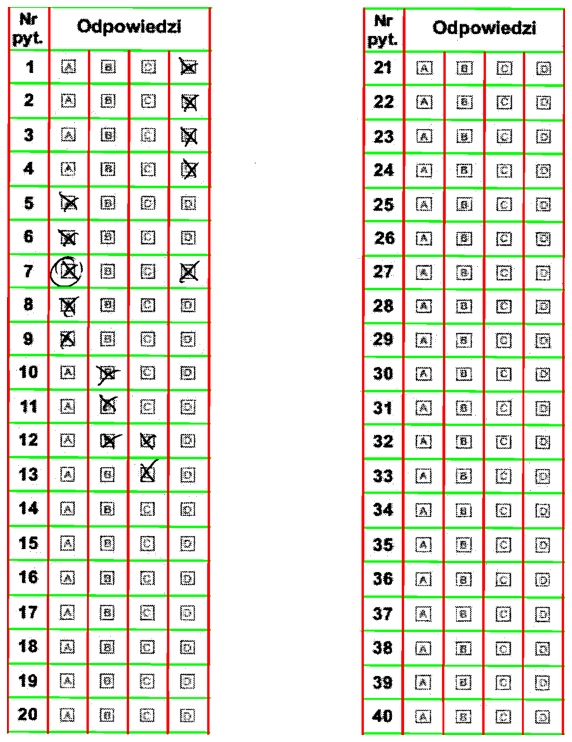

In [440]:
# show_image(answers_image)
# show_image(personal_image)

def detect_contours(threshhold, kernel_size: Tuple[int]):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    detect = cv2.morphologyEx(threshhold, cv2.MORPH_OPEN, kernel, iterations=2)
    contours = cv2.findContours(detect, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours[0] if len(contours) == 2 else contours[1]

answers_image[answers_image <= 170] = 0
answers_image[answers_image > 170] = 255
new_ans = answers_image.copy()

thresh = cv2.threshold(new_ans, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

new_ans = cv2.cvtColor(new_ans, cv2.COLOR_GRAY2RGB)

horizontal_contours = detect_contours(thresh, (40, 1))
vertical_contours = detect_contours(thresh, (1, 30))

cv2.drawContours(new_ans, horizontal_contours, -1, (0,255,0), 2)
cv2.drawContours(new_ans, vertical_contours, -1, (255,0,0), 2)

show_image(new_ans, None)